This notebook was preparing by Kevin Mathew <br>Objective :To compare queries using sql and python.
<br>Different methods avaiable in either languages will be used and their performance will be compared whereever possible.<br>
Support for other programming langugaages will be added later<br>

Credit: <br>
Following are the notes prepared while working on Databases and SQL by the [The Carpentries](https://swcarpentry.github.io/sql-novice-survey/about/index.html)

### [Survey DB](https://swcarpentry.github.io/sql-novice-survey/)

In the late 1920s and early 1930s, William Dyer, Frank Pabodie, and Valentina Roerich led expeditions to the Pole of Inaccessibility in the South Pacific, and then onward to Antarctica. Two years ago, their expeditions were found in a storage locker at Miskatonic University. We have scanned and OCR the data they contain, and we now want to store that information in a way that will make search and analysis easy.

### Connecting to the database with JupyterLab

[ip-python-sql](https://pypi.org/project/ipython-sql/)

Credits: Parul Pandey<br>[Click here for the complete tutorial](https://www.datacamp.com/community/tutorials/sql-interface-within-jupyterlab)



In [181]:
import pandas as pd
import numpy as np
from IPython.display import Image
from IPython.core.display import display, HTML

In [141]:
#Lets connect to the database using sql magic
%load_ext sql
%sql sqlite:////Users/kevinmathew/sql/survey.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [142]:
# Now,lets excecute queries on our database and create the respective dataframes for operations using pandas.

person=%sql select * from person,site,survey,visited
site=%sql select * from site
survey=%sql select * from survey
visited=%sql select * from visited


person=person.DataFrame()
site=site.DataFrame()
survey=survey.DataFrame()
visited=visited.DataFrame()

 * sqlite:////Users/kevinmathew/sql/survey.db
Done.
 * sqlite:////Users/kevinmathew/sql/survey.db
Done.
 * sqlite:////Users/kevinmathew/sql/survey.db
Done.
 * sqlite:////Users/kevinmathew/sql/survey.db
Done.


#### 1.Filtering 
One of the most powerful features of a database is the ability to filter data, i.e., to select only those records that match certain criteria. For example, suppose we want to see when a particular site was visited. We can select these records from the Visited table by using a WHERE clause in our query:

In [143]:
%%time 
%sql SELECT * FROM Visited WHERE site = 'DR-1' AND dated < '1930-01-01';

 * sqlite:////Users/kevinmathew/sql/survey.db
Done.
CPU times: user 2.56 ms, sys: 1.17 ms, total: 3.73 ms
Wall time: 3.21 ms


id,site,dated
619,DR-1,1927-02-08
622,DR-1,1927-02-10


In [144]:
%%time
visited[(visited.site=='DR-1') & (visited.dated<='1930-01-01')]

CPU times: user 1.85 ms, sys: 661 µs, total: 2.52 ms
Wall time: 2.47 ms


,id,site,dated
0,619,DR-1,1927-02-08
1,622,DR-1,1927-02-10


#### 1.1 Partial Matching : LIKE OPERATOR

In [145]:
%%time 
# the site names beginning with “DR
%sql select * from visited where site LIKE 'ms%';

 * sqlite:////Users/kevinmathew/sql/survey.db
Done.
CPU times: user 2.31 ms, sys: 1.06 ms, total: 3.37 ms
Wall time: 2.42 ms


id,site,dated
837,MSK-4,1932-01-14


In [146]:
### There are two methods to perform this using pandas,

## Lets compare the time taken for both- these approaches, 


%timeit visited2=pd.concat([visited]*1000,ignore_index=True)
%timeit visited2[visited2['site'].str.contains(r'MS(?!$)')]
%timeit visited2[visited2['site'].str.contains('MS',regex=False)]

58.8 ms ± 6.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.47 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.28 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Performance wise, regex search is slower than substring search.<br>
Anything that is not a string cannot have string methods applied on it, so we can specify 'na=False' here.<br>
[source](https://stackoverflow.com/questions/11350770/select-by-partial-string-from-a-pandas-dataframe)

In [147]:
## Multiple Substring search using list and join
terms=['MS','DR']
visited[visited['site'].str.contains('|'.join(terms))]

,id,site,dated
0,619,DR-1,1927-02-08
1,622,DR-1,1927-02-10
2,734,DR-3,1930-01-07
3,735,DR-3,1930-01-12
4,751,DR-3,1930-02-26
5,752,DR-3,None
6,837,MSK-4,1932-01-14
7,844,DR-1,1932-03-22


#### 2.Calculating New Values on the fly

In [148]:
%%time
%sql SELECT 1.05 * reading FROM Survey WHERE quant = 'rad';

 * sqlite:////Users/kevinmathew/sql/survey.db
Done.
CPU times: user 2.68 ms, sys: 1.35 ms, total: 4.03 ms
Wall time: 5.36 ms


1.05 * reading
10.311
8.19
8.8305
7.581
4.5675
2.2995
1.533
11.8125


In [159]:
%sql SELECT * FROM Survey limit 5

 * sqlite:////Users/kevinmathew/sql/survey.db
Done.


taken,person,quant,reading
619,dyer,rad,9.82
619,dyer,sal,0.13
622,dyer,rad,7.8
622,dyer,sal,0.09
734,pb,rad,8.41


In [160]:
#survey['new_reading']=survey[survey['quant']=='rad']['reading']*1.05
### There is a problem with this approach,because there will be null values for the boolean false

#survey['reading']=(np.where(survey['quant']=='rad',survey['reading']*1.05,np.where(survey['quant']!='rad',survey['reading'])))
# Above method is also not working here

In [176]:
##The solution is to use a transform function inside the apply
def transform_row(r):
    if r.quant =='rad':
        r.reading=r.reading * 1.05
    else:
        r.reading=r.reading
    return r 

survey.apply(transform_row,axis=1).head(5)

,taken,person,quant,reading
0,619,dyer,rad,10.3110
1,619,dyer,sal,0.1300
2,622,dyer,rad,8.1900
3,622,dyer,sal,0.0900
4,734,pb,rad,8.8305


#### 2.1 Combining values from two different fields

In [163]:
%sql SELECT personal || ' ' || family as fullname FROM Person;

 * sqlite:////Users/kevinmathew/sql/survey.db
Done.


fullname
William Dyer
Frank Pabodie
Anderson Lake
Valentina Roerich
Frank Danforth


In Pandas there are [several ways](https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-pandas-dataframe) to do this. 

In [177]:
columns=['personal','family']
person['fullname']=person[columns].astype(str).sum(axis=1)

A graph comparing performance of these approaches by [Anton](https://stackoverflow.com/users/7386332/anton-vbr)<br>
Its always good to subscirbe to the rss feeds of top 1% users in each domain.


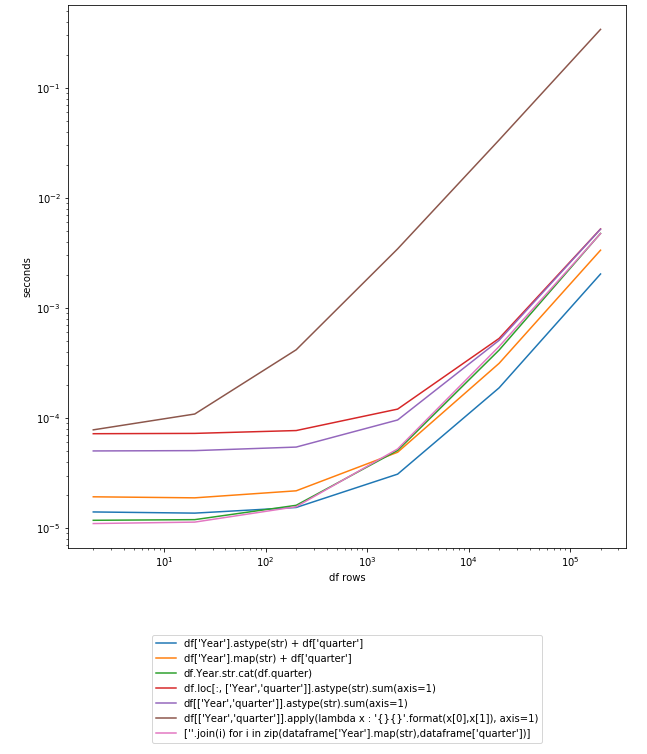

In [182]:
Image("https://i.stack.imgur.com/QaLDM.png")

#### 3.Missing Data

We have to be careful in dealing with null values

In [187]:
%sql select count(*) from visited


 * sqlite:////Users/kevinmathew/sql/survey.db
Done.


count(*)
8


In [215]:
%sql SELECT (select count(*) FROM Visited WHERE dated < '1930-01-01')+\
(SELECT count(*) FROM Visited WHERE dated >= '1930-01-01')\
AS Sum_count

 * sqlite:////Users/kevinmathew/sql/survey.db
Done.


Sum_count
7


In [216]:
visited[visited['dated']< '1930-01-01'].shape[0] + visited[visited['dated']>= '1930-01-01'].shape[0]

7

As we can see here, one record is missing in both set of results. This happend because, there is one record having date as null,so comparison operator on this wont return either true or false<br>

In [218]:
## To find null values in sql, use 'IS NULL'

%sql select * from visited where dated is null

 * sqlite:////Users/kevinmathew/sql/survey.db
Done.


id,site,dated
752,DR-3,None
